In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
np.random.seed(1234)
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 4.1

Distribution of random walks

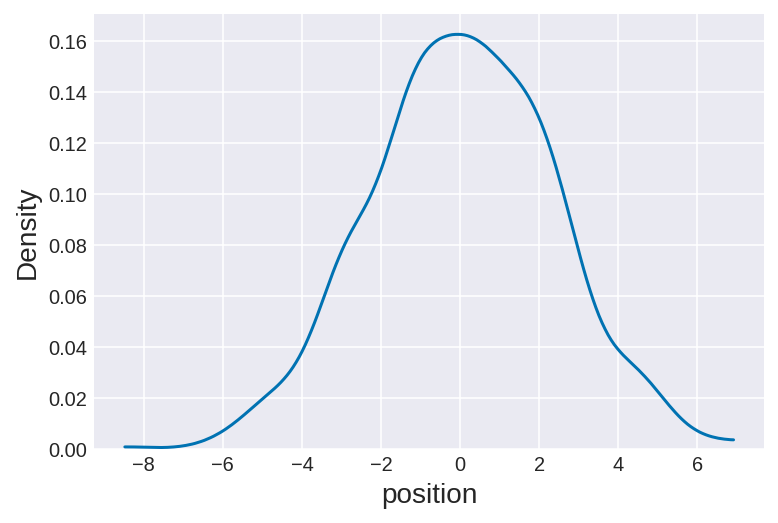

In [2]:
pos = np.random.uniform(-1, 1, size=(16, 1000))
posSum = pos.sum(0)
pm.kdeplot(posSum)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

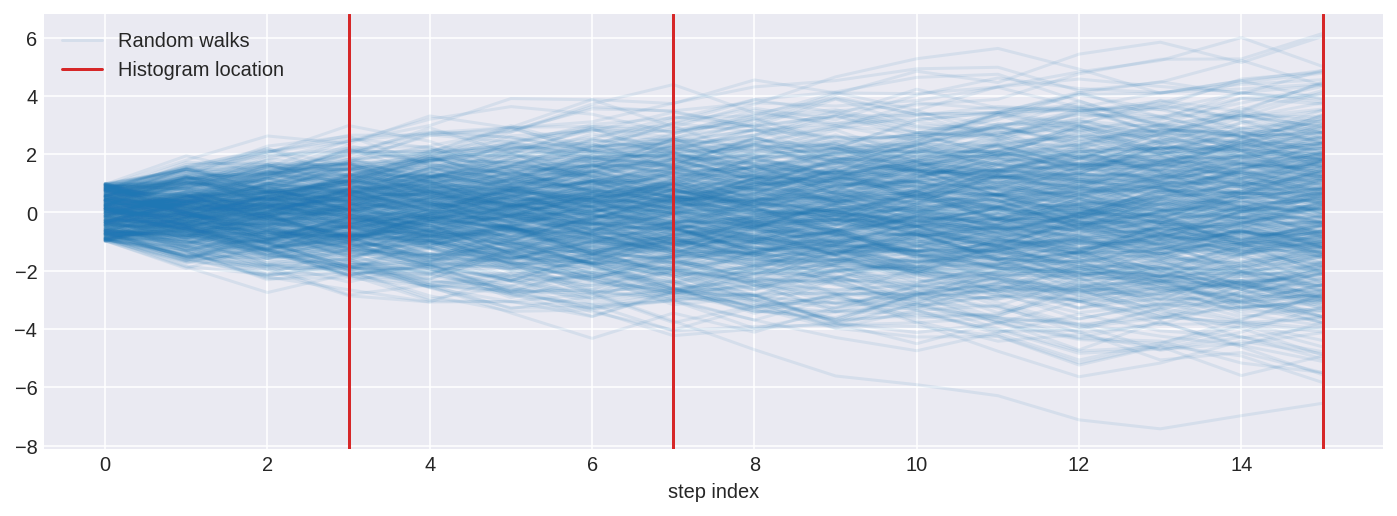

In [3]:
fig, ax = plt.subplots(figsize=(12,4))
positionAtEachStep = np.cumsum(pos, axis=0)
ax.plot(positionAtEachStep[:,0],color='tab:blue',alpha=0.1, label='Random walks');
ax.plot(positionAtEachStep[:,:500],color='tab:blue',alpha=0.1);
ax.set_xlabel('step index');
ax.axvline(x=3, color='tab:red', label='Histogram location');
ax.axvline(x=7, color='tab:red');
ax.axvline(x=15, color='tab:red');
ax.legend();

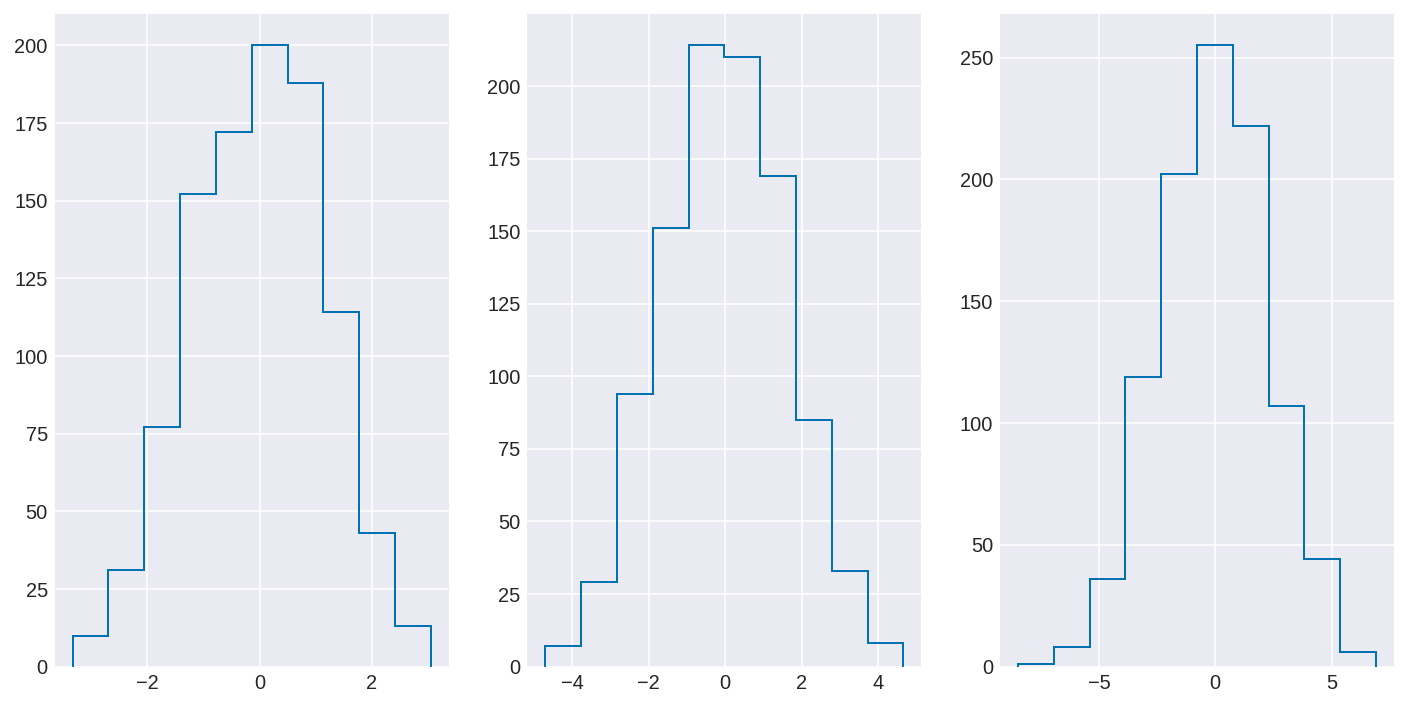

In [4]:
fig ,ax = plt.subplots(1,3,figsize=(12,6))
_=ax[0].hist(positionAtEachStep[3,:],histtype='step');
_=ax[1].hist(positionAtEachStep[7,:],histtype='step');
_=ax[2].hist(positionAtEachStep[15,:],histtype='step');

#### Code 4.2 and 4.3

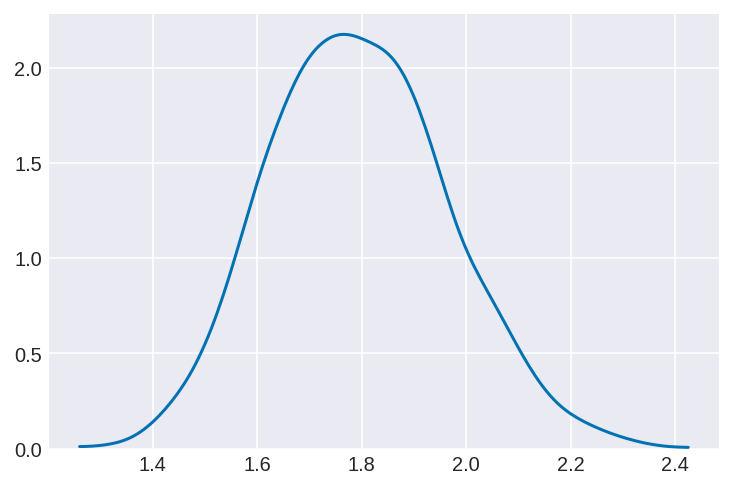

In [5]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pm.kdeplot(pos);

#### Code 4.4

Small multiplicative interactions are normal, because they approximate additions

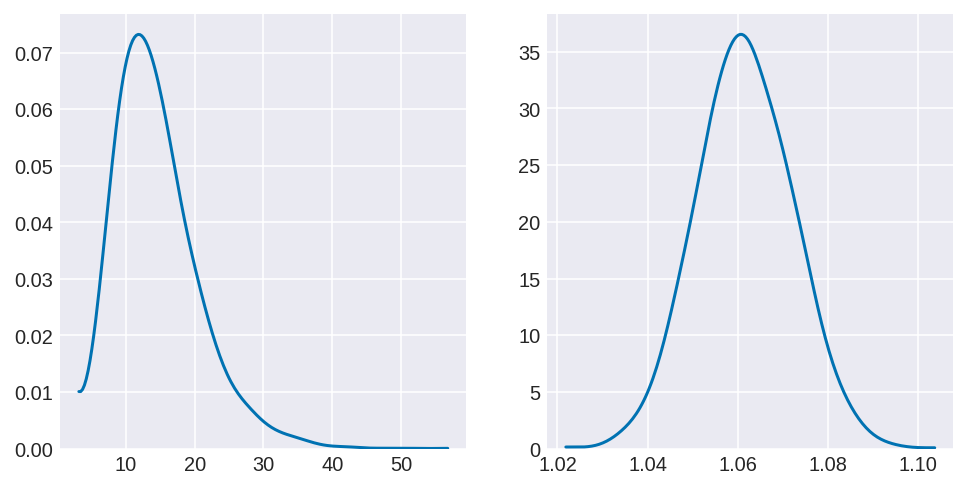

In [6]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(big, ax=ax[0])
pm.kdeplot(small, ax=ax[1]);

#### Code 4.5

Large deviates that are multiplied together tend to produce Gaussian distributions on the log scale, because adding logs is equivalent to multiplying the original numbers

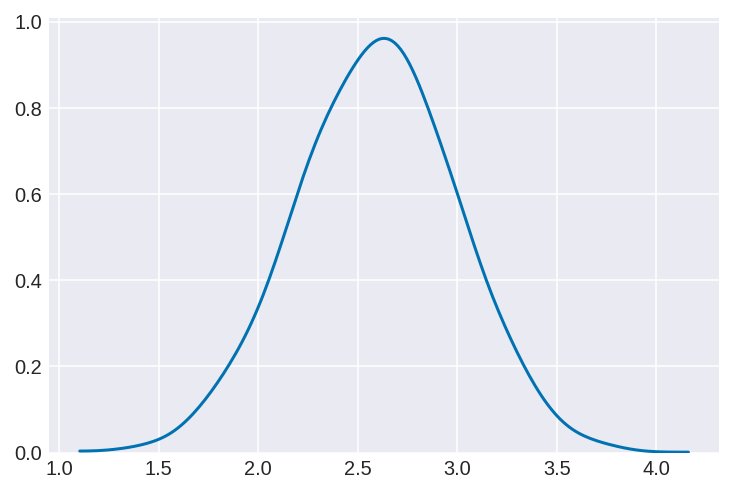

In [7]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
pm.kdeplot(log_big);

#### Code 4.6

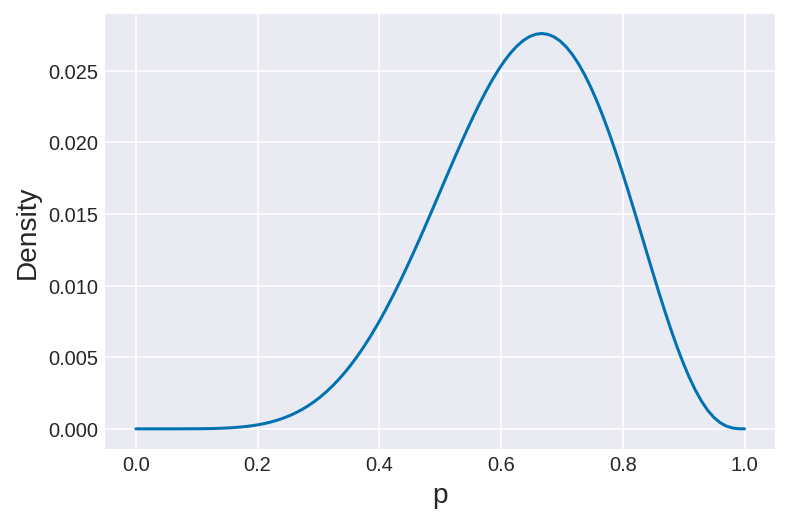

In [8]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel('p', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 4.7 and 4.8

In [9]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

In [10]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [11]:
d2 = d[d.age >= 18]

#### Code 4.11

Prior on the mean of the heights

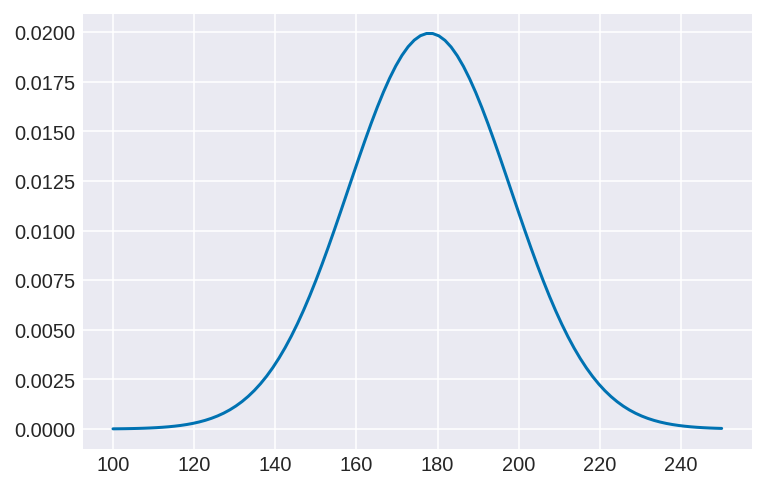

In [12]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

Prior on the standard deviation of the heights

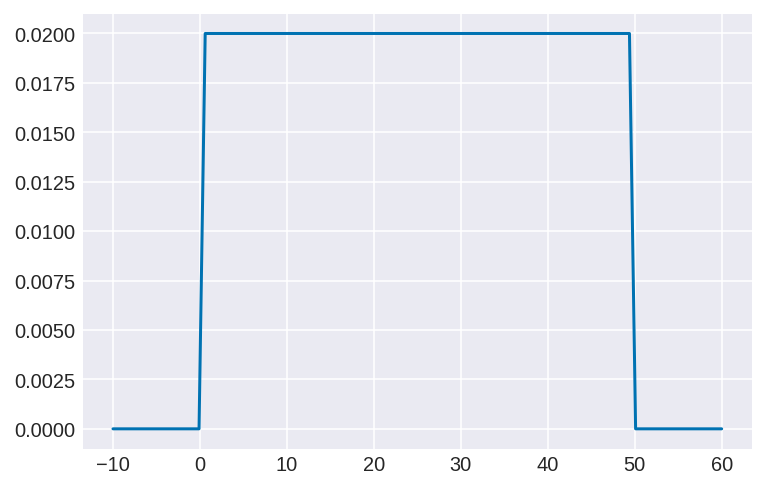

In [13]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13

Sample from the prior: the distribution of relative plausibilities of different heights, before seeing the data.

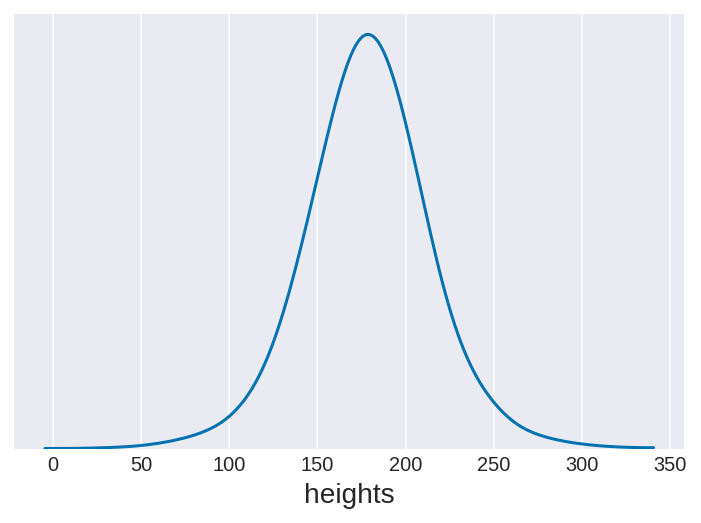

In [14]:
n_samples = 10000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

#### Code 4.14

In [15]:
# grid of means (rows) and standard deviations (columns)
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T
# likelihood for every combination of parameters, using the data
likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]
# posterior. we use logpdf to sum rather than multiply
post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
# we need to raise to the exponential since we took the log before to get probabilities
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.15 and 4.16

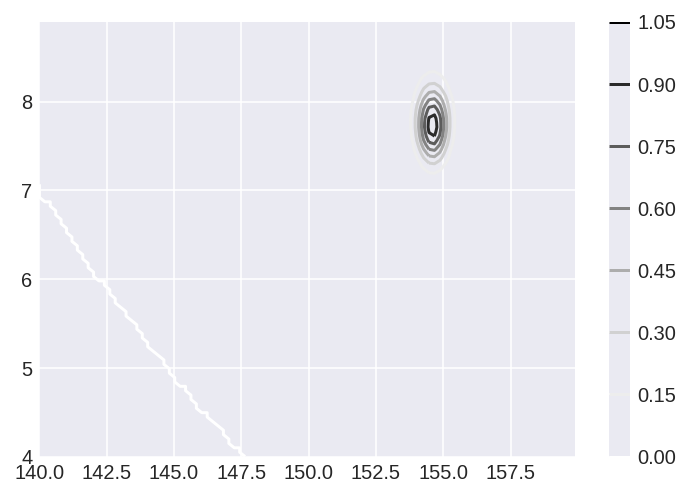

In [16]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);
plt.colorbar();

#### Code 4.17 and 4.18

Posterior probability of parameters

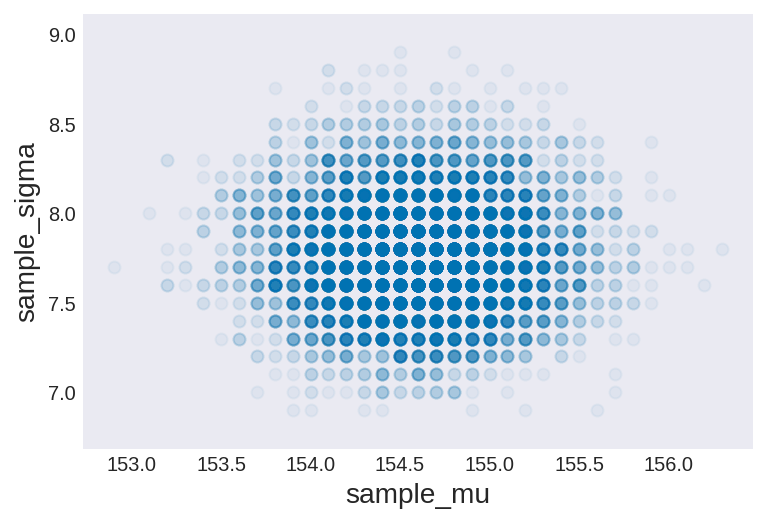

In [17]:
# sample parameter values from posterior based on their probability
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))

sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14);

#### Code 4.19

Marginal (averaging over the other parameters) distributions of parameters

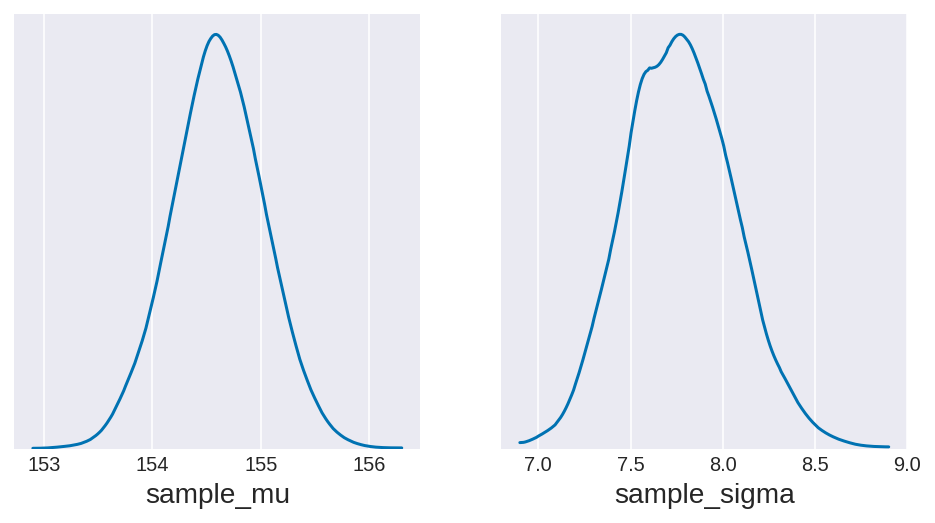

In [18]:
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu', fontsize=14)
ax[0].set_yticks([])
pm.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma', fontsize=14)
ax[1].set_yticks([]);

#### Code 4.20

In [19]:
pm.hpd(sample_mu), pm.hpd(sample_sigma)

(array([153.8, 155.4]), array([7.3, 8.4]))

#### Code 4.21 and  4.22

Repeat the posterior calculation but now with a smaller sample size

In [20]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post2[:,0][i], scale=post2[:,1][i])) for i in range(len(post2))]

post_prod2 = (likelihood2 + 
              stats.norm.logpdf(post2[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post2[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(np.arange(len(post2)), size=10000, replace=True, 
                               p=(post_prob2/post_prob2.sum()))
sample_mu2 = post2[:,0][sample_rows2]
sample_sigma2 = post2[:,1][sample_rows2]

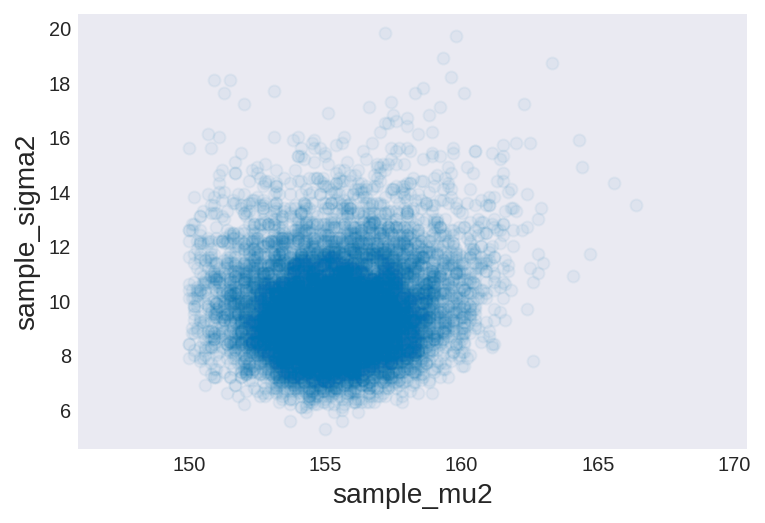

In [21]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2', fontsize=14)
plt.ylabel('sample_sigma2', fontsize=14)
plt.grid(False)

#### Code 4.23

Smaller samples sizes make the sigma uncertainty to have a long right tail (see text)

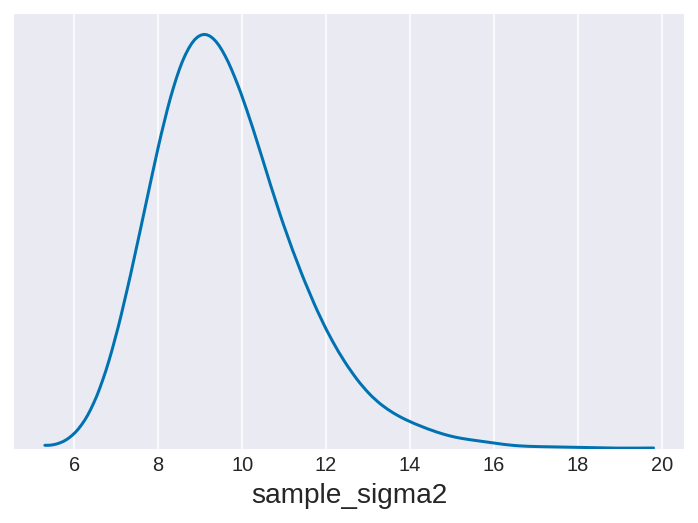

In [22]:
pm.kdeplot(sample_sigma2)
plt.xlabel('sample_sigma2', fontsize=14)
plt.yticks([]);

#### Code 4.24

We are repeating code 4.7, 4.8 and 4.10

In [23]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.25

In [24]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.26

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [25]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 5200.09draws/s]


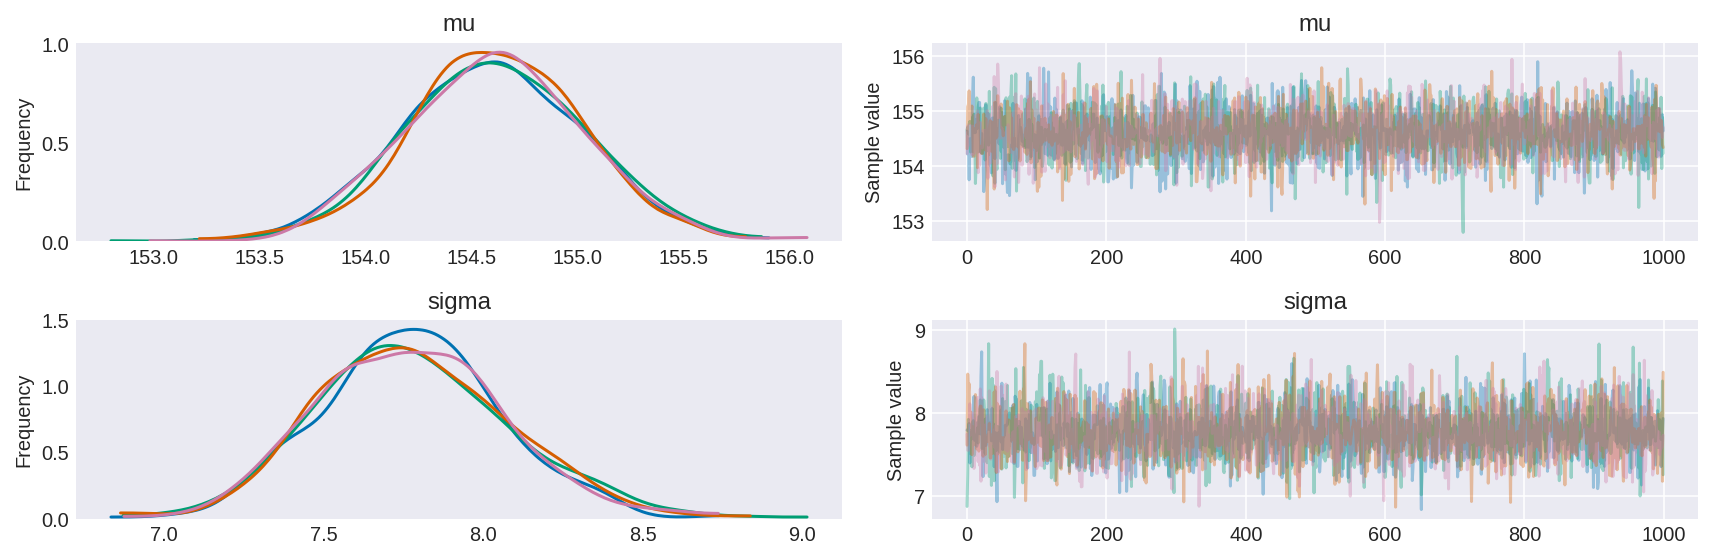

In [26]:
pm.traceplot(trace_4_1); # this function let you check the samples values

#### Code 4.27

Notice that compared to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples.

In [27]:
pm.summary(trace_4_1, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     154.60  0.42      0.01   153.93    155.25  3658.89   1.0
sigma    7.77  0.30      0.00     7.32      8.26  4442.99   1.0

#### Code 4.28

In [28]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 5006.48draws/s]


mean   sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     154.61  0.4      0.01   153.94    155.22  4353.69   1.0
sigma    7.78  0.3      0.00     7.28      8.24  4212.25   1.0

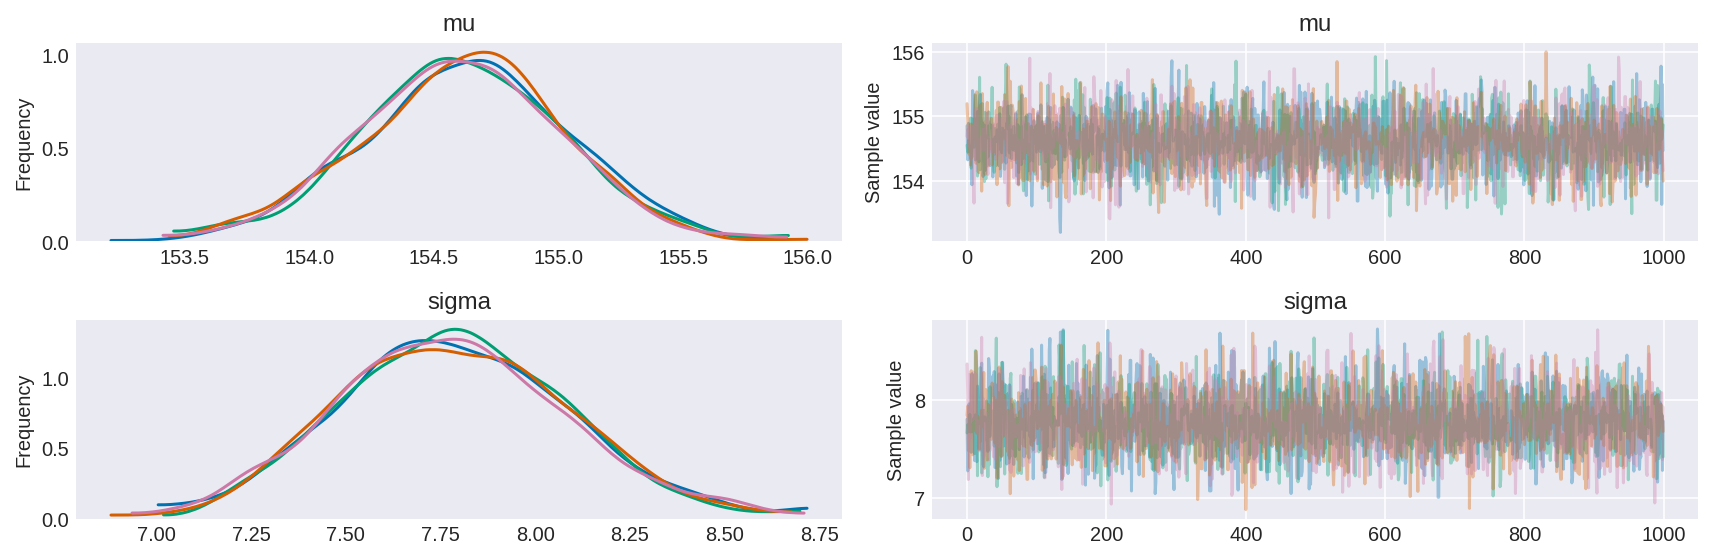

In [29]:
pm.traceplot(trace_4_1); 
pm.summary(trace_4_1, alpha=.11).round(2)

#### Code 4.29

In [30]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 5183.37draws/s]


In [31]:
pm.summary(trace_4_2, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     177.86  0.10      0.00   177.70    178.02  3612.94   1.0
sigma   24.63  0.94      0.02    23.13     26.06  3893.92   1.0

#### Code 4.30

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [32]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.163478  0.003305
sigma  0.003305  0.090743

#### Code 4.31

In [33]:
np.diag(trace_df.cov())

array([0.1634777 , 0.09074263])

In [34]:
trace_df.corr()

mu     sigma
mu     1.000000  0.027135
sigma  0.027135  1.000000

#### Code 4.32

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [35]:
trace_df.head()

mu     sigma
0  154.853729  7.799949
1  154.326711  7.273010
2  154.891317  7.844011
3  154.371802  7.956873
4  154.536464  7.771239

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [36]:
trace_4_1['sigma'][:10]

array([7.7999486 , 7.27301034, 7.84401081, 7.95687341, 7.77123853,
       7.77123853, 7.46242059, 8.26269883, 7.5902037 , 7.65339501])

#### Code 4.33

In our case, this is the same we did in the code 4.27

In [37]:
pm.summary(trace_4_1, alpha=.11).round(2)

mean   sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
mu     154.61  0.4      0.01   153.94    155.22  4353.69   1.0
sigma    7.78  0.3      0.00     7.28      8.24  4212.25   1.0

#### Code 4.34

Extracting posterior samples using a multivariate Gaussian

In [38]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.22610362,   8.48005694],
       [154.90650333,   8.18194059],
       [154.33655504,   8.15406563],
       [153.72555013,   7.13333172],
       [153.82025043,   7.70998052],
       [154.58221349,   7.70677162],
       [154.04138982,   8.23682475],
       [154.43575237,   7.67150126],
       [153.78983727,   7.83528755],
       [154.94119384,   7.73039086]])

#### Code 4.35 and 4.36

Instead of sampling from a normal and then exponentiating to ensure sigma is positive, we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where: 

$$tau=\frac{1}{\sigma^2}$$

The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience. 

In [39]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 5248.20draws/s]


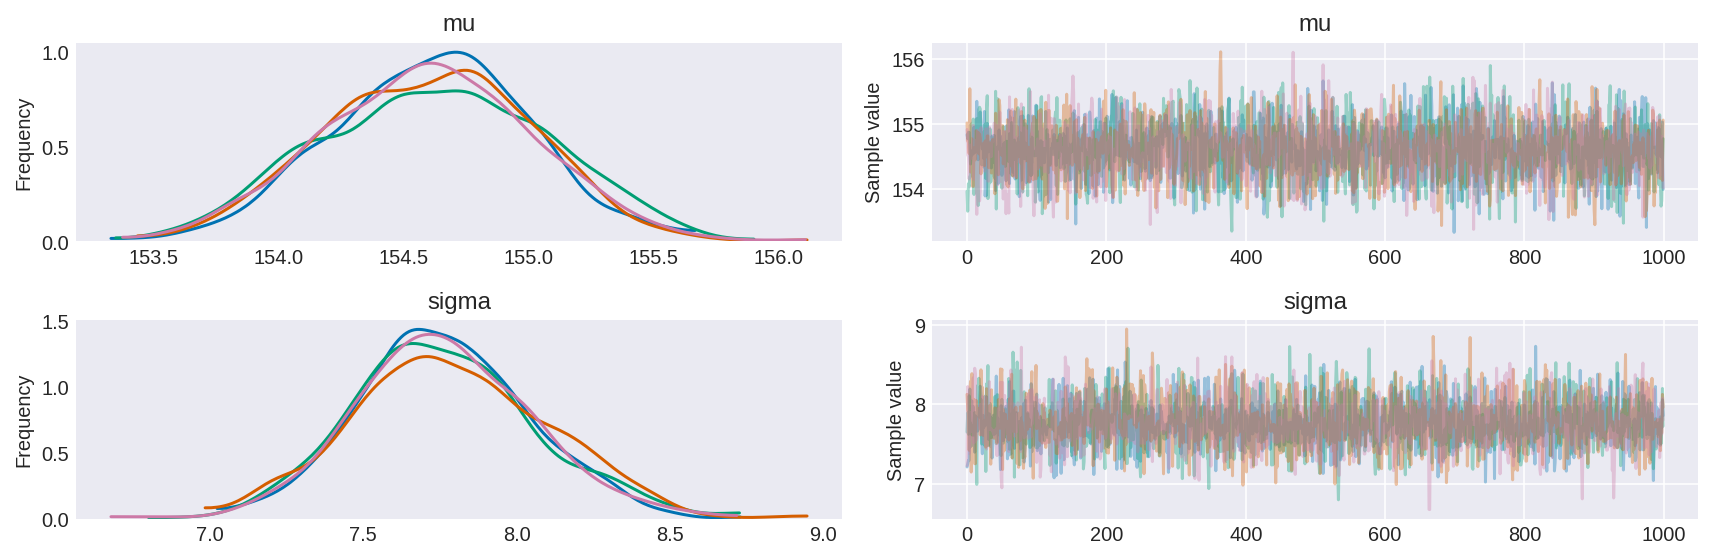

In [40]:
pm.traceplot(trace_4_1_logsigma);

#### Code 4.37

We are going to create a regression problem by looking at height vs. weight

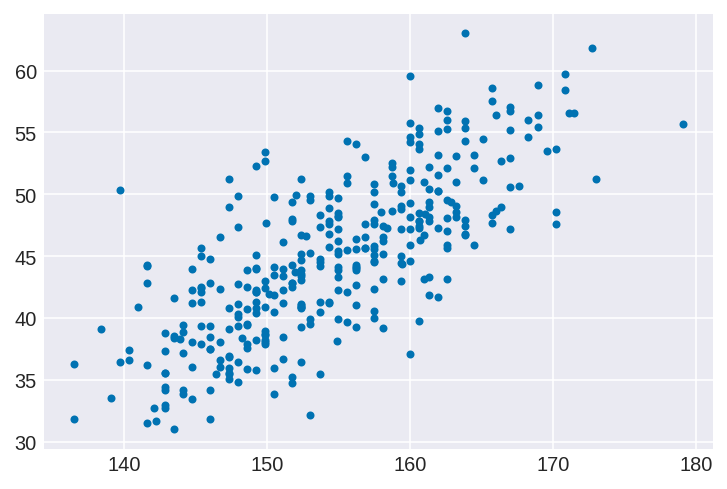

In [41]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38 and 4.39

Notice that the variable mu is defined as alpha + beta * d2.weight in a single line. If we want the trace to contain mu we can write as a deterministic varible. The computating will be exactly the same. The only difference is that mu will be accessible in the trace.

In [42]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1285.42draws/s]
The acceptance probability does not match the target. It is 0.8901576840894936, but should be close to 0.8. Try to increase the number of tuning steps.


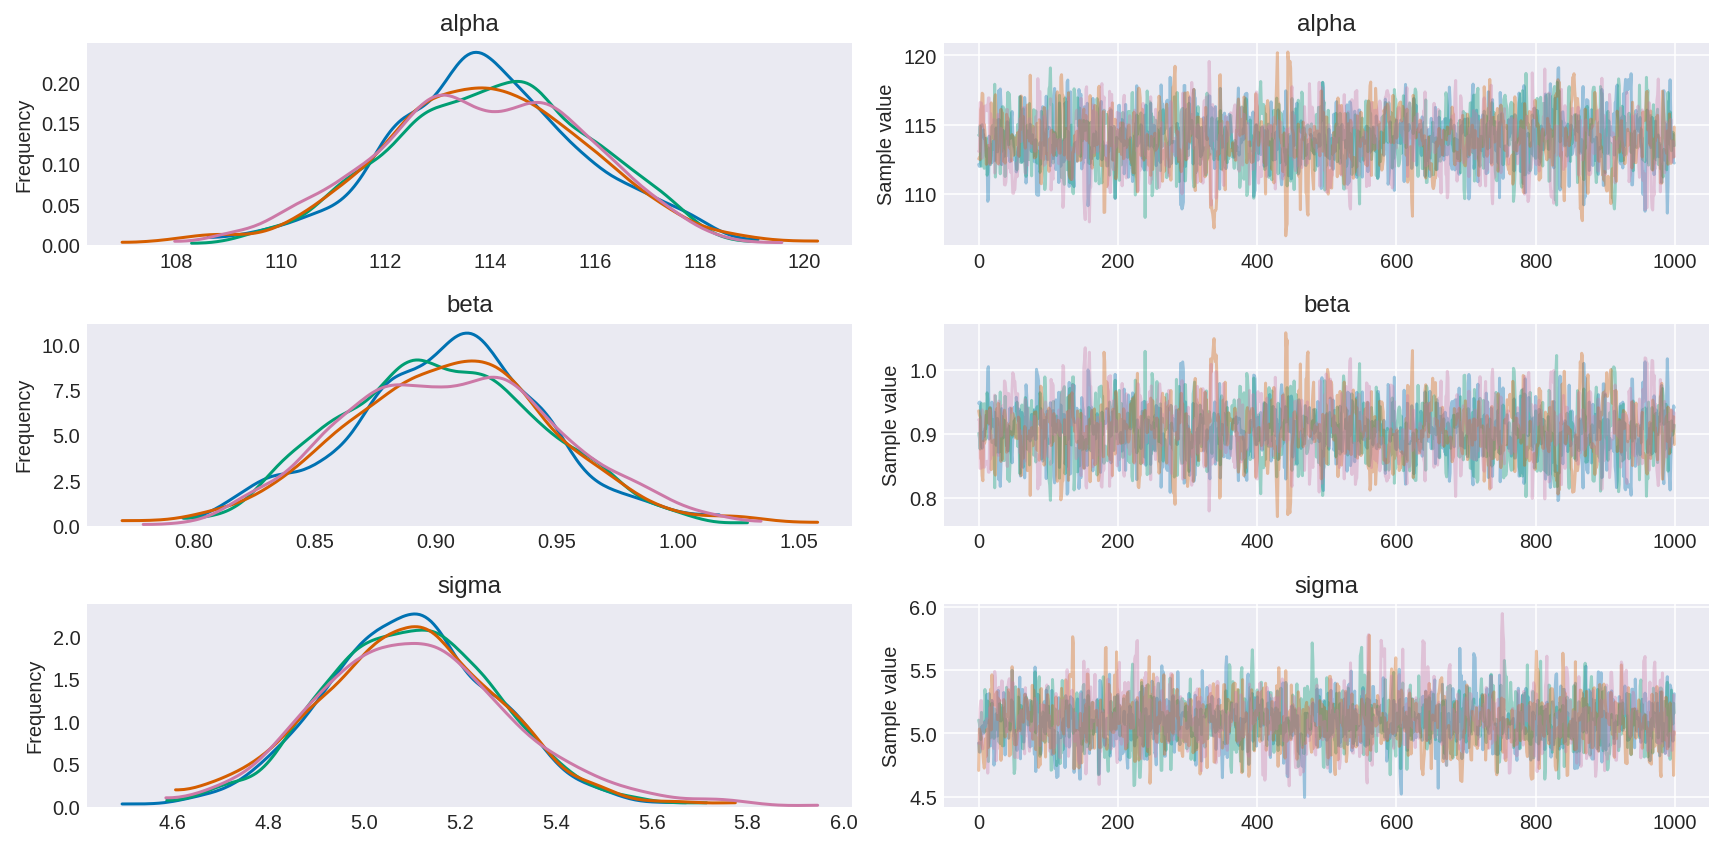

In [43]:
pm.traceplot(trace_4_3);

Another alternative is to write mu inside the likelihood and not as a separate line.

    height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)
    
Using PyMC3 there is not too much reason to do this. I personally think that defining mu in a separate line improves readability.

#### Code 4.40

In [44]:
pm.summary(trace_4_3, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha  113.91  1.93      0.05   111.14    117.33  1532.97   1.0
beta     0.90  0.04      0.00     0.83      0.97  1545.63   1.0
sigma    5.10  0.19      0.00     4.79      5.38  1888.48   1.0

#### Code 4.41

In [45]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

alpha  beta  sigma
alpha   1.00 -0.99  -0.02
beta   -0.99  1.00   0.01
sigma  -0.02  0.01   1.00

#### Code 4.42

Fit with centering of the data

In [46]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))

#### Code 4.43

In [47]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4157.38draws/s]


#### Code 4.44

In [48]:
pm.summary(trace_4_4, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha  154.59  0.27       0.0   154.17    155.00  5099.44   1.0
beta     0.90  0.04       0.0     0.84      0.97  5284.11   1.0
sigma    5.10  0.19       0.0     4.80      5.40  5985.91   1.0

In [49]:
trace_df = pm.trace_to_dataframe(trace_4_4)
trace_df.corr().round(2)

alpha  beta  sigma
alpha   1.00  0.00  -0.04
beta    0.00  1.00   0.01
sigma  -0.04  0.01   1.00

#### Code 4.45

Instead of using the MAP, we are going to use the mean of the posterior 

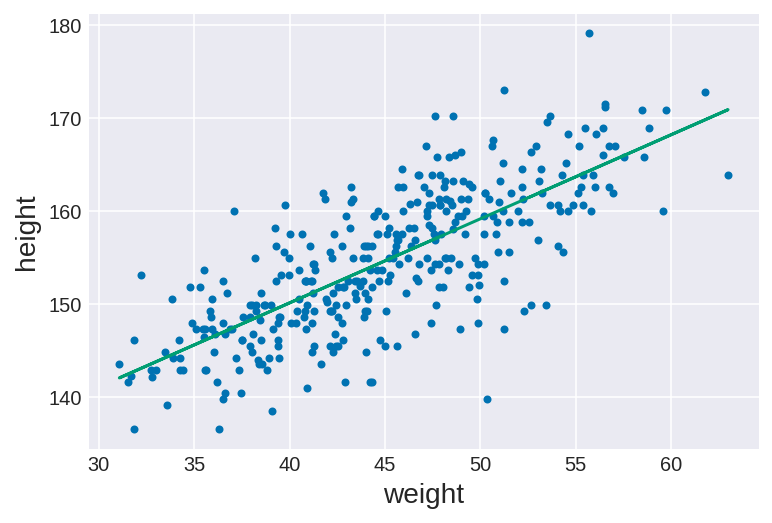

In [50]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.46 and 4.47

In [51]:
pm.trace_to_dataframe(trace_4_4)[:5]

alpha      beta     sigma
0  154.452799  0.931172  5.383987
1  154.699304  0.933228  5.291386
2  154.730447  0.906038  5.380697
3  154.849058  0.888175  4.763616
4  154.856682  0.901224  5.088676

#### Code 4.48 & Code 4.49

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1664.85draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1599.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1462.12draws/s]
The acceptance probability does not match the target. It is 0.9096290421780605, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUT

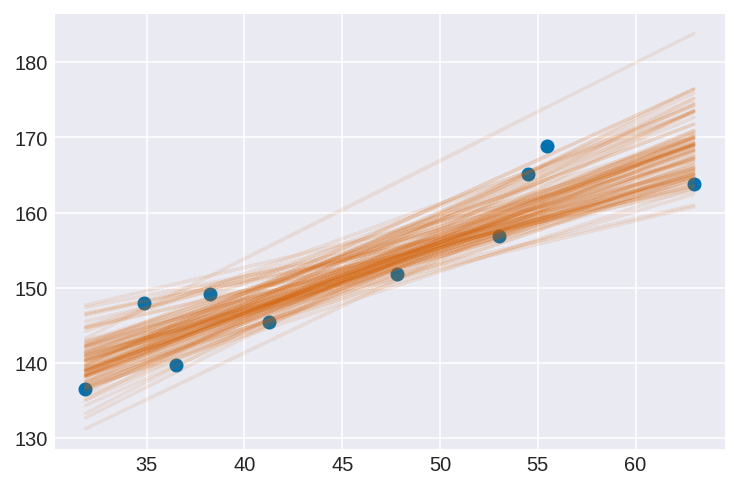

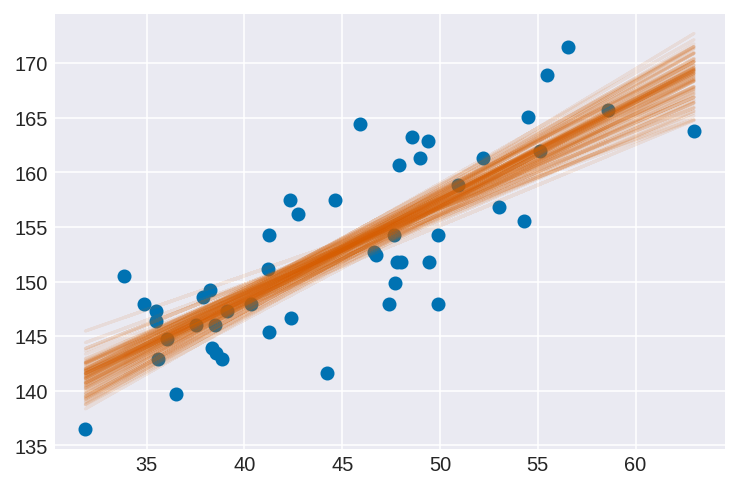

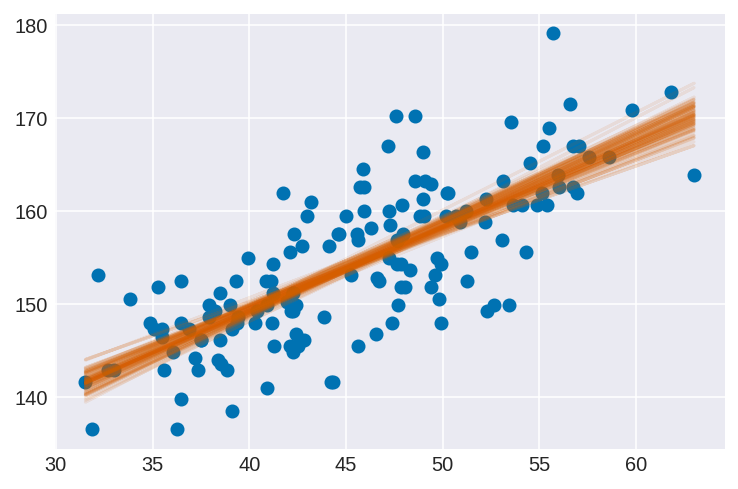

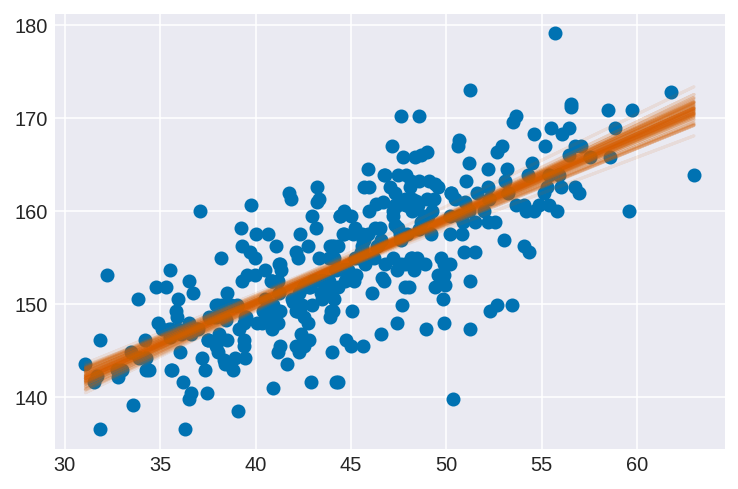

In [52]:
N = [10, 50, 150, 352]
m10 = pm.Model()
m50 = pm.Model()
m150 = pm.Model()
m352 = pm.Model()
m = [m10,m50,m150,m352]
nLines = 100
for i, n in enumerate(N):
    with m[i]:
        alpha = pm.Normal('alpha', mu=178, sd=100)
        beta = pm.Normal('beta', mu=0, sd=10)
        sigma = pm.Uniform('sigma', lower=0, upper=50)
        mu = pm.Deterministic('mu', alpha + beta * d2.weight[:n])
        height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:n])
        trace_N = pm.sample(1000, tune=1000)
    fig, ax = plt.subplots()
    ax.plot(d2.weight[:n],d2.height[:n], 'C0o')
    for idx_ in range(nLines):
        idx = np.random.randint(0,len(trace_N))
        ax.plot(d2.weight[:n],trace_N['mu'][idx], 'C2-', alpha=0.1)

#### Code 4.50 and 4.51

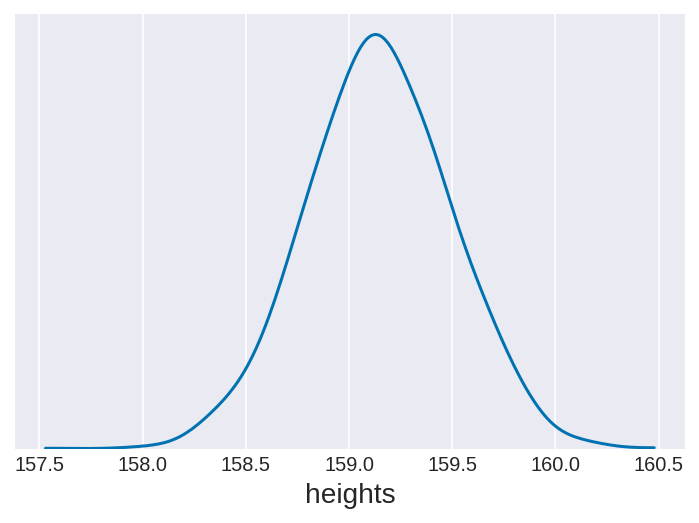

In [53]:
mu_at_50 = trace_N['alpha'] + trace_N['beta'] * 50
pm.kdeplot(mu_at_50)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

#### Code 4.52

In [54]:
pm.hpd(mu_at_50, alpha=.11)

array([158.58520093, 159.68797627])

#### Code 4.53

Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need.

In [55]:
df_trace_N = pm.trace_to_dataframe(trace_N).filter(regex=('mu.*'))
df_trace_N.head()

mu__0       mu__1       mu__2       mu__3       mu__4       mu__5  \
0  157.038545  146.518901  142.232145  161.877581  150.963450  171.108569   
1  157.317685  146.936572  142.706269  162.092997  151.322592  171.202423   
2  157.317685  146.936572  142.706269  162.092997  151.322592  171.202423   
3  157.200857  145.691513  141.001455  162.495156  150.554211  172.594605   
4  157.792522  145.934771  141.102738  163.247087  150.944671  173.652263   

        mu__6       mu__7       mu__8       mu__9     ...         mu__342  \
0  148.149445  164.139305  145.019851  163.218836     ...      153.514464   
1  148.545645  164.324936  145.457264  163.416589     ...      153.840012   
2  148.545645  164.324936  145.457264  163.416589     ...      153.840012   
3  147.475461  164.969665  144.051431  163.962597     ...      153.345227   
4  147.772723  165.796503  144.245042  164.758950     ...      153.820175   

      mu__343     mu__344     mu__345     mu__346     mu__347     mu__348  \
0  157.091143  149.227709  150.753057  150.542664  156.302170  144.441271   
1  157.369591  149.609709  151.114970  150.907348  156.591007  144.886302   
2  157.369591  149.609709  151.114970  150.907348  156.591007  144.886302   
3  157.258404  148.655169  150.324024  150.093837  156.395203  143.418417   
4  157.851810  148.988142  150.707516  150.470361  156.962479  143.592866   

      mu__349     mu__350     mu__351  
0  161.062309  162.824349  161.404197  
1  161.288461  163.027297  161.625847  
2  161.288461  163.027297  161.625847  
3  161.603181  163.530997  161.977235  
4  162.328111  164.314284  162.713488  

[5 rows x 352 columns]

#### Code 4.54 and 4.58

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [56]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_N_thinned = trace_N[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_N_thinned)*trace_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_N_thinned['alpha'] + trace_N_thinned['beta'] * w

#### Code 4.55

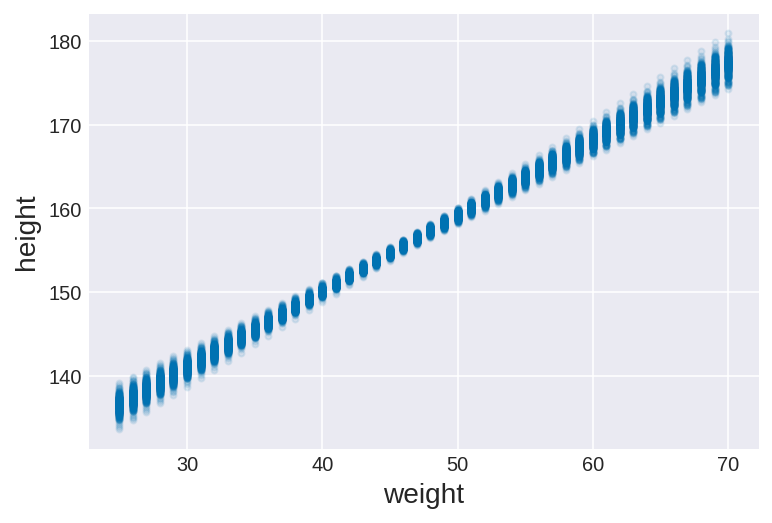

In [57]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

#### Code 4.56

In [58]:
mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)

#### Code 4.57

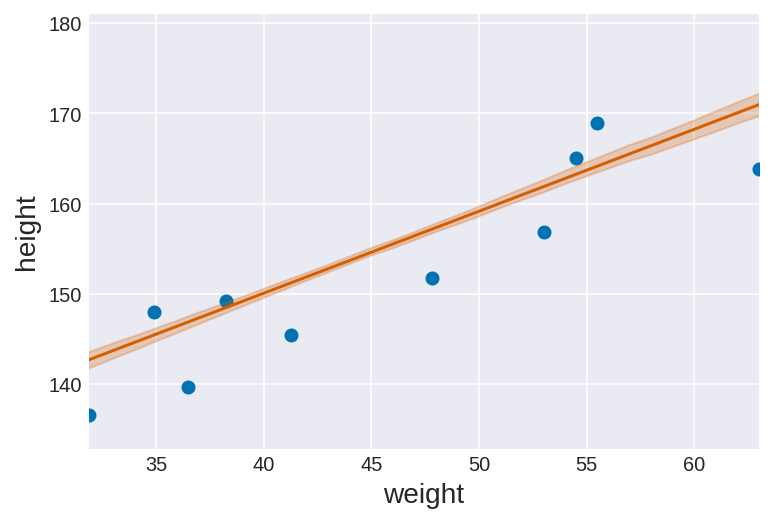

In [59]:
plt.scatter(d2.weight[:N[0]], d2.height[:N[0]])
plt.plot(weight_seq, mu_mean, 'C2')
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N[0]].min(), d2.weight[:N[0]].max());

#### Code 4.59

Now we are going to use ```sample_ppc()``` from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)

In [60]:
# model for the example
modelExample = m352
nExample = N[-1]

In [61]:
height_pred = pm.sample_ppc(trace_N, 2000, modelExample)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 2000/2000 [00:00<00:00, 2509.56it/s]


#### Code 4.60

In [62]:
height_pred_hpd = pm.hpd(height_pred['height_hat'])

#### Code 4.61
```sample_ppc``` returns values corresponding to the input values (weights in this example). Because the weights are not ordered if we use them with the ```fill_between``` function we will get a mess. For that reason in the following cell we order the weights and the predicted heights

In [63]:
idx = np.argsort(d2.weight.values[:nExample])
d2_weight_ord = d2.weight.values[:nExample][idx]
height_pred_hpd = height_pred_hpd[idx]

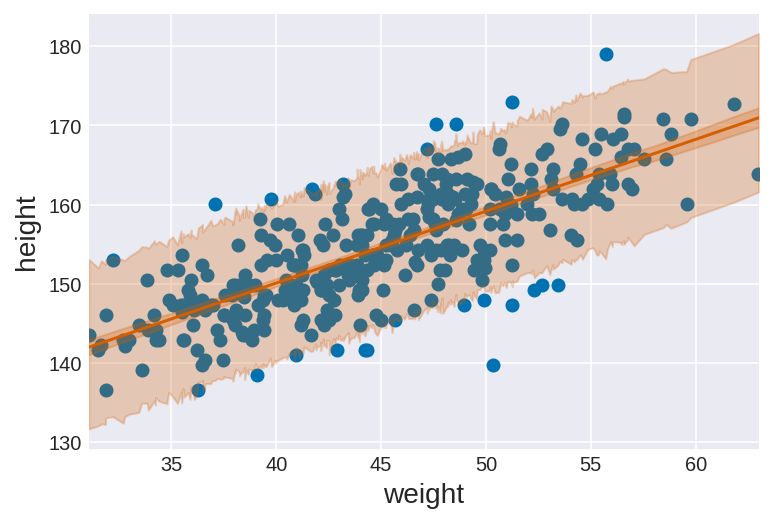

In [64]:
plt.scatter(d2.weight[:N[-1]], d2.height[:nExample])
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(d2_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.plot(weight_seq, mu_mean, 'C2')
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:nExample].min(), d2.weight[:nExample].max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book.

#### Code 4.63

Now we are going to generate heights from the posterior _manually_, instead of restricting to the input values we are going to pass an array of equally spaced weights values ```weight_seg```.

In [65]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(trace_N))
    mu_pred = trace_N['alpha'][i] + trace_N['beta'][i] * weight_seq
    sigma_pred = trace_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pred, sigma_pred))

In [66]:
post_samples_hpd = pm.hpd(np.array(post_samples))

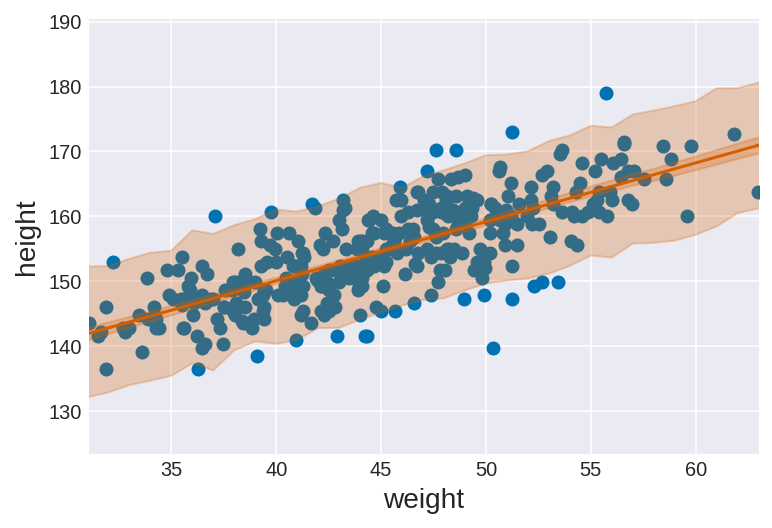

In [67]:
plt.scatter(d2.weight[:nExample], d2.height[:nExample])
plt.plot(weight_seq, mu_mean, 'C2')
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(weight_seq, post_samples_hpd[:,0], post_samples_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [68]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.65

In [69]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

#### Code 4.66

In [70]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2911.71draws/s]


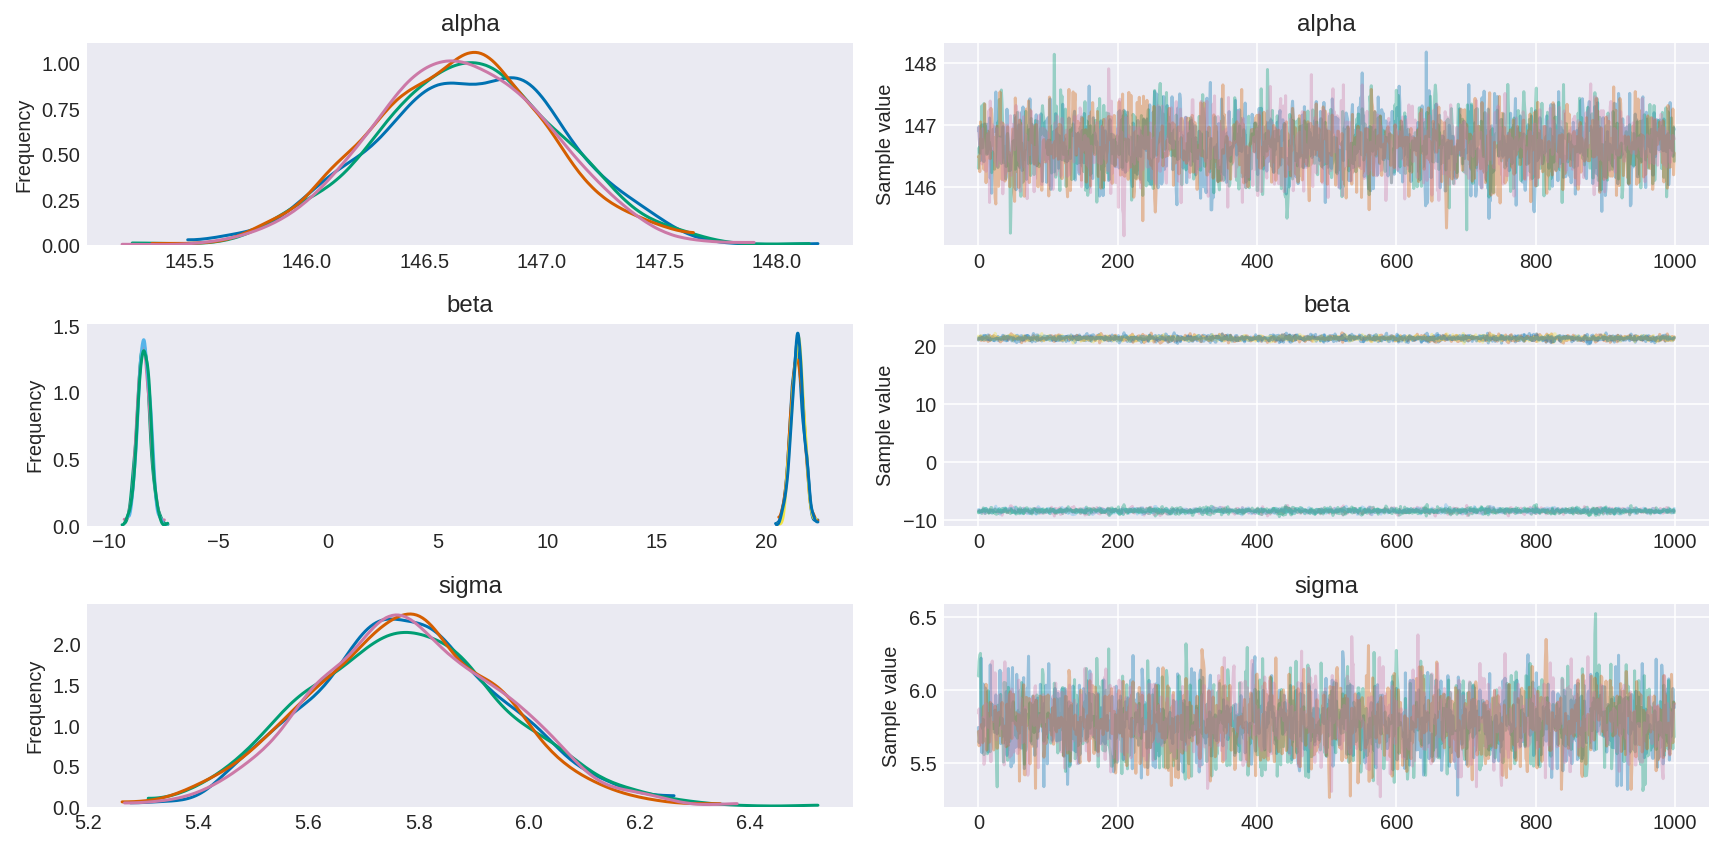

In [71]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace_4_5, varnames);

#### Code 4.67

In [72]:
pm.summary(trace_4_5, varnames, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha    146.66  0.38      0.01   146.05    147.26  2889.64   1.0
beta__0   21.40  0.29      0.01    20.96     21.89  3013.60   1.0
beta__1   -8.42  0.29      0.01    -8.86     -7.96  2638.25   1.0
sigma      5.78  0.17      0.00     5.52      6.07  3253.40   1.0

#### Code 4.68

In [73]:
mu_pred = trace_4_5['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 200/200 [00:00<00:00, 1722.46it/s]


#### Code 4.69

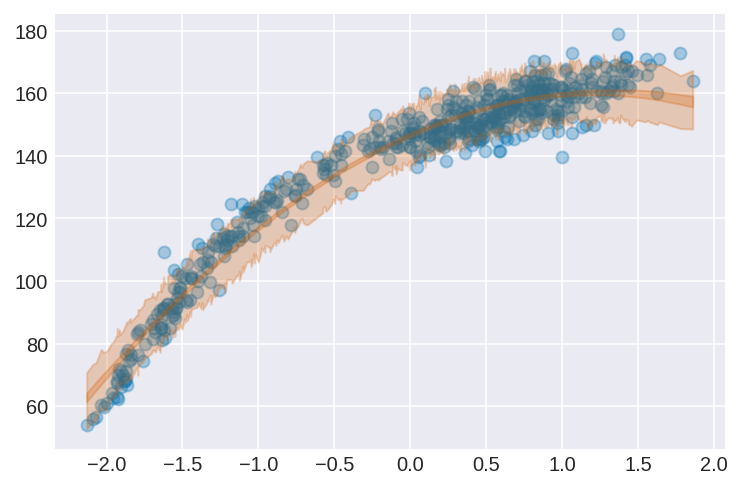

In [74]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

#### Code 4.70

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [75]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [76]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2271.40draws/s]


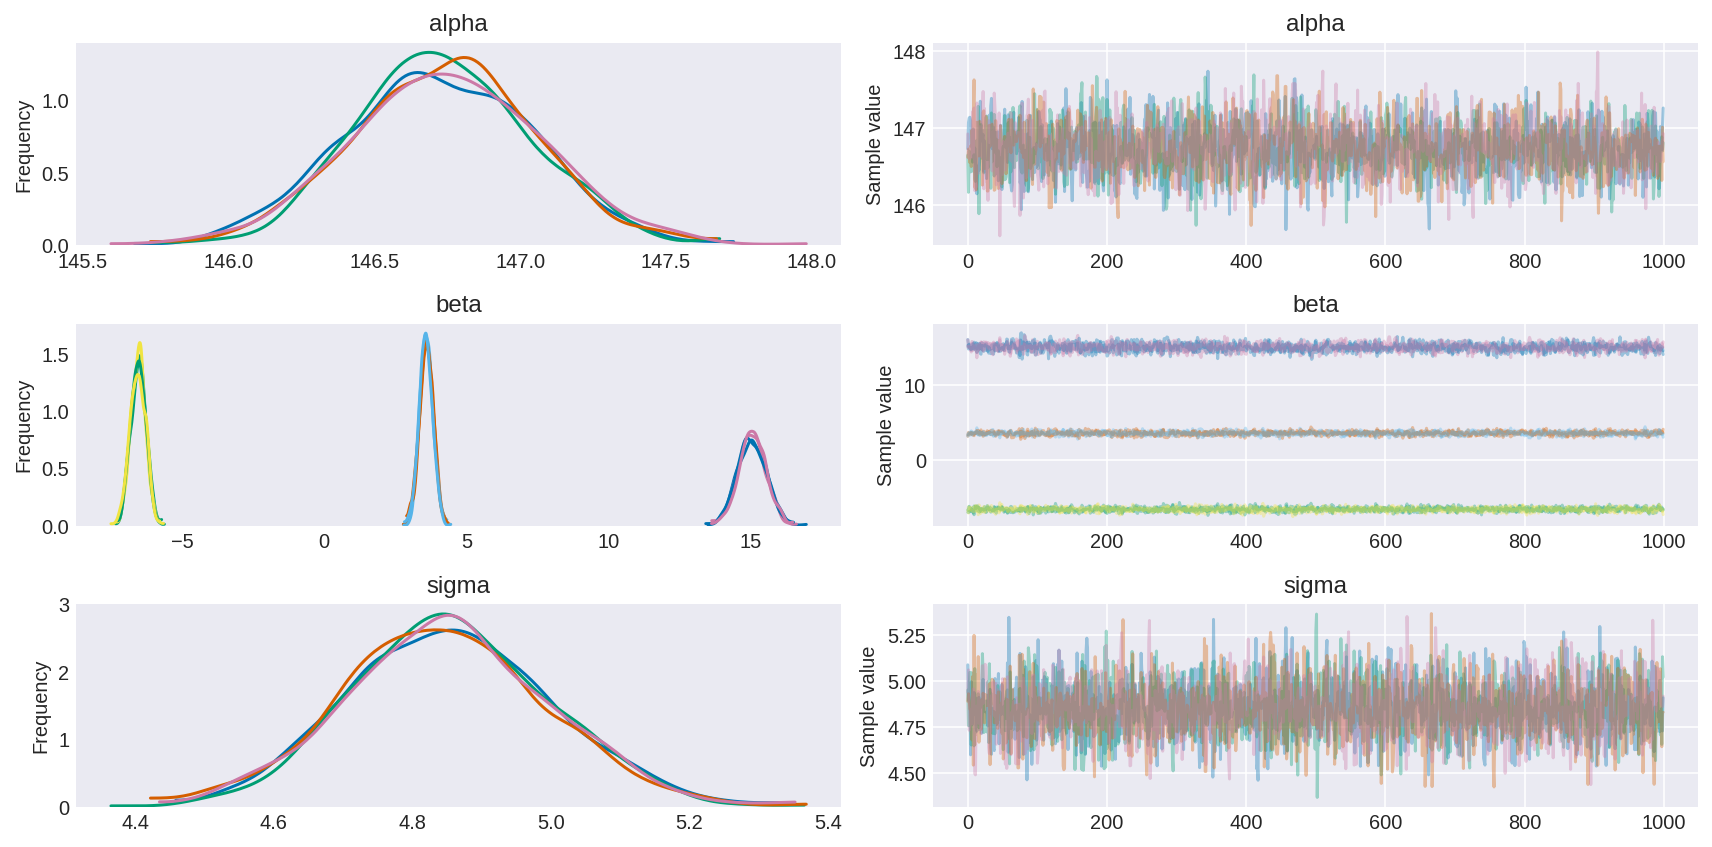

In [77]:
pm.traceplot(trace_4_6, varnames);

#### Code 4.71 and 4.72

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """
100%|██████████| 200/200 [00:00<00:00, 1824.13it/s]


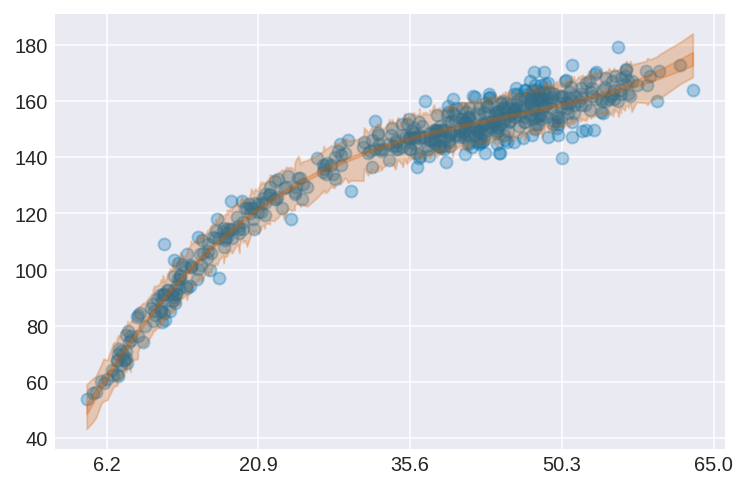

In [78]:
mu_pred = trace_4_6['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred, alpha=.11)[idx]

height_pred = pm.sample_ppc(trace_4_6, 200, m_4_6)
height_pred_hpd = pm.hpd(height_pred['height'], alpha=.11)[idx]

plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [79]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.15.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
